In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, optimizers, layers

### 1. 准备数据

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

**数据分割**

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


**归一化**

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 2. 模型构建

In [5]:
x_train.shape[1:]

(8,)

#### 1. 使用函数式 API

In [6]:
input = layers.Input(shape=x_train.shape[1:])
hidden1 = layers.Dense(30, activation="relu")(input)
hidden2 = layers.Dense(30, activation="relu")(hidden1)

concat = layers.concatenate([input, hidden2])
output = layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input], outputs = [output])

model.summary()
model.compile(loss="mean_squared_error", optimizers="sgd")
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-2)
]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [7]:
# model.build?

In [8]:
history = model.fit(x_train_scaled, y_train, 
                    validation_data=(x_valid_scaled, y_valid),
                   epochs=100, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 202us/sample - loss: 1.5682 - val_loss: 0.6022
Epoch 2/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4785 - val_loss: 0.4651
Epoch 3/100
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4089 - val_loss: 0.3962
Epoch 4/100
11610/11610 [==============================] - 1s 71us/sample - loss: 0.3802 - val_loss: 0.3908
Epoch 5/100
11610/11610 [==============================] - 1s 90us/sample - loss: 0.3630 - val_loss: 0.3727
Epoch 6/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.3539 - val_loss: 0.3517
Epoch 7/100
11610/11610 [==============================] - 1s 70us/sample - loss: 0.3497 - val_loss: 0.3456
Epoch 8/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.3472 - val_loss: 0.3443
Epoch 9/100
11610/11610 [==============================] - 1s 82us/sample - loss: 0.34

In [9]:
# model.fit?

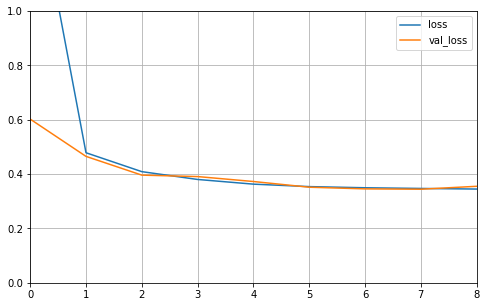

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [11]:
model.evaluate(x_test_scaled, y_test, verbose=2)

5160/1 - 0s - loss: 0.5093


0.43965419905130254

#### 2. 使用子类 API实现

In [12]:
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = layers.Dense(1)
    
    def call(self, input):
        """完成模型的正向运算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output
    
widedeepmodel = WideDeepModel()
# widedeepmodel = keras.Sequential([
#     WideDeepModel(),
# ])
widedeepmodel.build(input_shape=(None, 8))
widedeepmodel.summary()
widedeepmodel.compile(loss="mean_squared_error", optimizers="sgd")
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = widedeepmodel.fit(x_train_scaled, y_train, 
                    validation_data=(x_valid_scaled, y_valid),
                   epochs=100, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 149us/sample - loss: 1.0092 - val_loss: 0.5314
Epoch 2/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4388 - val_loss: 0.4156
Epoch 3/100
11610/11610 [==============================] - 1s 78us/sample - loss: 0.4005 - val_loss: 0.3914
Epoch 4/100
11610/11610 [==============================] - 1s 71us/sample - loss: 0.3659 - val_loss: 0.3745
Epoch 5/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3509 - val_loss: 0.3535
Epoch 6/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3432 - val_loss: 0.3544
Epoch 7/100
11610/11610 [==============================] - 1s 90us/sample - loss: 0.3333 - val_loss: 0.3521
Epoch 8/100
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3355 - val_loss: 0.3413
Epoch 9/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.32

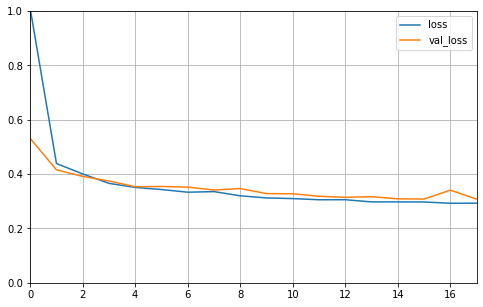

In [14]:
plot_learning_curves(history)

In [15]:
widedeepmodel.evaluate(x_test_scaled, y_test, verbose=2)

5160/1 - 0s - loss: 0.4374


0.3404532072618026

#### 3. wide deep 多输入

In [20]:
# 数据一共 8 个特征，我们把前 5 个输入到 wide 模型， 后 6 个输入到 deep 模型
input_wide = layers.Input(shape=[5])
input_deep = layers.Input(shape=[6])
hidden1 = layers.Dense(30, activation='relu')(input_deep)
hidden2 = layers.Dense(30, activation='relu')(hidden1)
concat = layers.concatenate([input_wide, hidden2])
output = layers.Dense(1)(concat)

model3 = keras.models.Model(inputs=[input_wide, input_deep], outputs=[output])

# model3.summary()
model3.compile(loss="mean_squared_error", optimizers="sgd")
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-2)
]

In [18]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

history = model3.fit([x_train_scaled_wide, x_train_scaled_deep], y_train, 
                    validation_data=([x_valid_scaled_wide, x_valid_scaled_deep], y_valid),
                   epochs=100, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 151us/sample - loss: 1.2898 - val_loss: 0.6881
Epoch 2/100
11610/11610 [==============================] - 1s 89us/sample - loss: 0.5658 - val_loss: 0.4989
Epoch 3/100
11610/11610 [==============================] - 1s 95us/sample - loss: 0.4371 - val_loss: 0.4375
Epoch 4/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4027 - val_loss: 0.4066
Epoch 5/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.3860 - val_loss: 0.3851
Epoch 6/100
11610/11610 [==============================] - 1s 102us/sample - loss: 0.3826 - val_loss: 0.3746
Epoch 7/100
11610/11610 [==============================] - 1s 99us/sample - loss: 0.3646 - val_loss: 0.3749
Epoch 8/100
11610/11610 [==============================] - 1s 107us/sample - loss: 0.3614 - val_loss: 0.3709
Epoch 9/100
11610/11610 [==============================] - 1s 91us/sample - loss: 0.

In [19]:
model3.evaluate([x_test_scaled_wide, x_test_scaled_deep], y_test, verbose=2)

5160/1 - 0s - loss: 0.5024


0.39564001227534096

#### 4. wide deep 多输出

In [22]:
# 数据一共 8 个特征，我们把前 5 个输入到 wide 模型， 后 6 个输入到 deep 模型
input_wide = layers.Input(shape=[5])
input_deep = layers.Input(shape=[6])
hidden1 = layers.Dense(30, activation='relu')(input_deep)
hidden2 = layers.Dense(30, activation='relu')(hidden1)
concat = layers.concatenate([input_wide, hidden2])
output = layers.Dense(1)(concat)
output2 = layers.Dense(1)(hidden2)

model3 = keras.models.Model(inputs=[input_wide, input_deep], 
                            outputs=[output, output2])

# model3.summary()
model3.compile(loss="mean_squared_error", optimizers="sgd")
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-2)
]

In [23]:
history = model3.fit([x_train_scaled_wide, x_train_scaled_deep], 
                     [y_train, y_train], 
                    validation_data=([x_valid_scaled_wide, x_valid_scaled_deep], 
                                     [y_valid, y_valid]),
                   epochs=20, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 247us/sample - loss: 3.1540 - dense_18_loss: 1.7191 - dense_19_loss: 1.4336 - val_loss: 1.3099 - val_dense_18_loss: 0.5900 - val_dense_19_loss: 0.7198
Epoch 2/20
11610/11610 [==============================] - 1s 114us/sample - loss: 1.0808 - dense_18_loss: 0.4773 - dense_19_loss: 0.6032 - val_loss: 1.0342 - val_dense_18_loss: 0.4470 - val_dense_19_loss: 0.5871
Epoch 3/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.9546 - dense_18_loss: 0.4118 - dense_19_loss: 0.5429 - val_loss: 0.9596 - val_dense_18_loss: 0.4136 - val_dense_19_loss: 0.5459
Epoch 4/20
11610/11610 [==============================] - 1s 96us/sample - loss: 0.8923 - dense_18_loss: 0.3869 - dense_19_loss: 0.5053 - val_loss: 0.8935 - val_dense_18_loss: 0.3891 - val_dense_19_loss: 0.5042
Epoch 5/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.8522 - dense_18_loss:

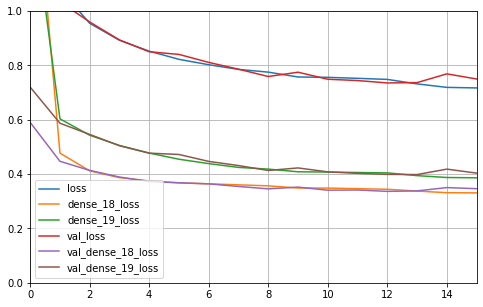

In [24]:
plot_learning_curves(history)

In [25]:
model3.evaluate([x_test_scaled_wide, x_test_scaled_deep],
               [y_test, y_test], verbose=2)

5160/1 - 0s - loss: 0.8618 - dense_18_loss: 0.3753 - dense_19_loss: 0.4042


[0.7787590827128684, 0.3753196, 0.40420806]